In [2]:
!pip install pandas
import pandas as pd
#merge datasets together
df1 = pd.read_csv("era5_heat_index_daily_il_counties_2023.csv")
df1.groupby("county")[[
    "heat_index_mean", 
    "heat_index_max", 
    "heat_index_min", 
    "heat_index_hours_above_90", 
    "heat_index_hours_above_104"
]].mean().reset_index()

  Using cached pandas-2.3.3-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.4-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.3-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.8 MB)
Using cached numpy-2.3.4-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.9 MB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)


,county,heat_index_mean,heat_index_max,heat_index_min,heat_index_hours_above_90,heat_index_hours_above_104
0,"Adams County, IL",55.524498,65.374677,45.491439,0.800000,0.180822
1,"Alexander County, IL",60.487031,70.542231,50.561118,1.224658,0.227397
2,"Bond County, IL",57.450366,67.107520,47.676687,0.854795,0.194521
3,"Boone County, IL",50.122224,58.745666,41.177494,0.282192,0.052055
4,"Brown County, IL",55.446166,65.419230,45.340783,0.775342,0.175342
...,...,...,...,...,...,...
97,"Whiteside County, IL",51.829183,61.022966,42.333030,0.438356,0.076712
98,"Will County, IL",52.313015,61.223025,43.228750,0.345205,0.068493
99,"Williamson County, IL",59.547213,69.379399,49.845336,1.008219,0.216438
100,"Winnebago County, IL",50.236531,59.041543,41.058722,0.306849,0.054795


In [3]:
import glob
from pathlib import Path

def load_syndromic(files):
    df_list = []
    for f in files:
        try:
            tmp = pd.read_csv(
                f,
                usecols=["HospitalRegion"],
                engine="python",
                encoding="utf-8",
                on_bad_lines="skip"
            )
            df_list.append(tmp)
        except Exception as e:
            print(f" Error reading {f}: {e}")
    if not df_list:
        return pd.DataFrame()
    return pd.concat(df_list, ignore_index=True)


base_path = Path.cwd().parents[1]


health_path_2023 = base_path / "essence" / "syndromic" / "2023"
files_2023 = list(health_path_2023.glob("*.csv"))

print(f" Found {len(files_2023)} CSV files for 2023")


health_2023 = load_syndromic(files_2023)


if not health_2023.empty:
    print("Data loaded successfully")
    print("Shape:", health_2023.shape)
    print(health_2023.head())
else:
    print("No valid data was loaded for 2023")
print("Shape:", health_2023.shape)

 Found 365 CSV files for 2023
Data loaded successfully
Shape: (5793829, 1)
  HospitalRegion
0          Logan
1          Logan
2          Logan
3          Logan
4          Logan
Shape: (5793829, 1)


In [8]:
region_counts = health_2023.groupby("HospitalRegion").size().reset_index(name="visit_count")
df1["county_clean"] = df1["county"].str.replace(" County, IL", "", regex=False)

county_vists = {}
for i, row in df1.iterrows():
    county = row["county_clean"]
    match = region_counts[region_counts["HospitalRegion"].str.lower()==county.lower()]
    if not match.empty:
        county_vists[row["county"]]=int(match["visit_count"].values[0])
    else:
        county_vists[row["county"]] = None

In [12]:
df1["visit_count"] = df1["county"].map(county_vists)
df_match= df1.dropna(subset=["visit_count"])
only_numeric = ["heat_index_mean", "heat_index_max", "heat_index_min", "heat_index_hours_above_90", "heat_index_hours_above_104", "visit_count"]

corr = df_match[only_numeric].corr()
print(corr)

                            heat_index_mean  heat_index_max  heat_index_min  \
heat_index_mean                    1.000000        0.985147        0.974749   
heat_index_max                     0.985147        1.000000        0.930568   
heat_index_min                     0.974749        0.930568        1.000000   
heat_index_hours_above_90          0.440717        0.459768        0.404427   
heat_index_hours_above_104         0.272806        0.288732        0.234024   
visit_count                       -0.048152       -0.062113       -0.030179   

                            heat_index_hours_above_90  \
heat_index_mean                              0.440717   
heat_index_max                               0.459768   
heat_index_min                               0.404427   
heat_index_hours_above_90                    1.000000   
heat_index_hours_above_104                   0.730530   
visit_count                                 -0.034745   

                            heat_index_hours_a

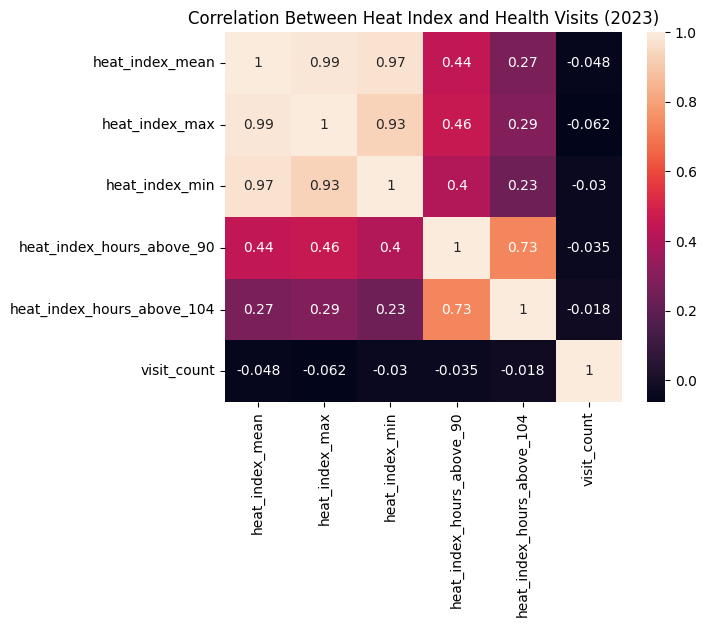

In [14]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(corr, annot=True)
plt.title("Correlation Between Heat Index and Health Visits (2023)")
plt.show()